In [51]:
# pip install tensorflow opencv-python mediapipe scikit-learn matplotlib

   ---------------------------------------- 0.0/1.7 MB ? eta -:--:--
   -- ------------------------------------- 0.1/1.7 MB 3.6 MB/s eta 0:00:01
   ----------- ---------------------------- 0.5/1.7 MB 6.3 MB/s eta 0:00:01
   ---------------------- ----------------- 0.9/1.7 MB 6.7 MB/s eta 0:00:01
   ---------------------------------------- 1.7/1.7 MB 9.8 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.12.1
    Uninstalling typing_extensions-4.12.1:
      Successfully uninstalled typing_extensions-4.12.1
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.3.0 requires typing-extensions>=4.8.0, but you have typing-extensions 4.5.0 which is incompatible.


In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.metrics import multilabel_confusion_matrix, confusion_matrix, accuracy_score, classification_report, roc_curve, auc, mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Conv1D, MaxPooling1D, Flatten, Dropout
from tensorflow.keras.callbacks import TensorBoard, EarlyStopping
from tensorflow.keras.models import load_model


## Przygotowanie danych

In [2]:
DATA_PATH = os.path.join('MP_Data')  
frames = 30                                            

actions = np.array(['car', 'coffee', 'face', 'fall', 'friday', 'gold', 'goodbye', 'heart', 'hello', 'iloveyou', 'key', 'monday', 'music', 'phone', 'pretty', 'saturday', 'spring', 'summer', 'sunday', 'tea', 'thanks', 'thursday', 'tuesday', 'wednesday', 'winter'])
label_map = {label:num for num, label in enumerate(actions)}

log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [3]:
sequences, labels = [], []
for action in actions:
    action_path = os.path.join(DATA_PATH, action)
    if not os.path.exists(action_path):
        print(f"Action path does not exist: {action_path}")
        continue
    
    sequences_list = os.listdir(action_path)
    if not sequences_list:
        print(f"No sequences found in path: {action_path}")
        continue
    
    for sequence in np.array(sequences_list).astype(int):
        window = []
        for frame_num in range(frames):
            frame_path = os.path.join(action_path, str(sequence), f"{frame_num}.npy")
            if not os.path.exists(frame_path):
                print(f"File does not exist: {frame_path}")
                continue
            
            res = np.load(frame_path)
            window.append(res)
        if window:
            sequences.append(window)
            labels.append(label_map[action])

print(f"Total sequences collected: {len(sequences)}")
print(f"Total labels collected: {len(labels)}")


Total sequences collected: 3750
Total labels collected: 3750


In [4]:
# Przygotowanie danych
X = np.array(sequences)
y = to_categorical(labels).astype(int)

# Podział na zbiór treningowy (70%) i zbiór tymczasowy (30%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Podział zbioru tymczasowego na zbiór walidacyjny (15%) i testowy (15%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Wyniki
print(f"Rozmiar zbioru treningowego: {len(X_train)}")
print(f"Rozmiar zbioru walidacyjnego: {len(X_val)}")
print(f"Rozmiar zbioru testowego: {len(X_test)}")

Rozmiar zbioru treningowego: 2625
Rozmiar zbioru walidacyjnego: 562
Rozmiar zbioru testowego: 563


In [5]:
print('X', X.shape)
print('y', y.shape)
print(X_train.shape, 'X_train')
print(X_test.shape, 'X_test')
print(y_train.shape, 'y_train') 
print(y_test.shape, 'y_test')

X (3750, 30, 258)
y (3750, 25)
(2625, 30, 258) X_train
(563, 30, 258) X_test
(2625, 25) y_train
(563, 25) y_test


In [7]:
actions.shape[0]

25

In [14]:
# Inicjalizacja callbacku wczesnego stopu
early_stopping = EarlyStopping(
    monitor='val_loss',                     # Metryka do monitorowania 
    patience=15,                            # Liczba epok bez poprawy, po których trening zostanie zatrzymany
    verbose=1,                              # Poziom logowania
    restore_best_weights=True               # Przywrócenie najlepszych wag modelu
)

## LSTM

In [15]:
# Defninicja modelu
model_lstm = Sequential()
model_lstm.add(LSTM(32, return_sequences=True, activation='relu', input_shape=(30, 258)))
model_lstm.add(LSTM(64, return_sequences=True, activation='relu'))
model_lstm.add(LSTM(32, return_sequences=False, activation='relu'))
model_lstm.add(Dropout(0.1))
model_lstm.add(Dense(32, activation='relu'))
model_lstm.add(Dense(actions.shape[0], activation='softmax'))

In [16]:
# Kompliacja modelu LSTM
model_lstm.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Trenowanie modelu LSTM
history_lstm = model_lstm.fit(
    X_train, y_train, 
    epochs=500, 
    batch_size=16, 
    callbacks=[tb_callback, early_stopping], 
    validation_data=(X_val, y_val)
)

Epoch 1/500
165/165 [==============================] - 9s 28ms/step - loss: 2.8786 - categorical_accuracy: 0.1162 - val_loss: 2.4623 - val_categorical_accuracy: 0.1868
Epoch 2/500
165/165 [==============================] - 4s 24ms/step - loss: 2.2628 - categorical_accuracy: 0.1756 - val_loss: 2.1367 - val_categorical_accuracy: 0.2260
Epoch 3/500
165/165 [==============================] - 3s 21ms/step - loss: 1.9842 - categorical_accuracy: 0.2709 - val_loss: 2.2040 - val_categorical_accuracy: 0.1993
Epoch 4/500
165/165 [==============================] - 4s 21ms/step - loss: 1.7458 - categorical_accuracy: 0.3615 - val_loss: 1.8432 - val_categorical_accuracy: 0.3399
Epoch 5/500
165/165 [==============================] - 4s 23ms/step - loss: 1.5212 - categorical_accuracy: 0.4438 - val_loss: 1.2826 - val_categorical_accuracy: 0.5463
Epoch 6/500
165/165 [==============================] - 4s 21ms/step - loss: 1.3519 - categorical_accuracy: 0.5017 - val_loss: 1.2520 - val_categorical_accuracy:

In [37]:
model_lstm.save('LSTM', save_format='tf')

INFO:tensorflow:Assets written to: LSTM\assets


INFO:tensorflow:Assets written to: LSTM\assets


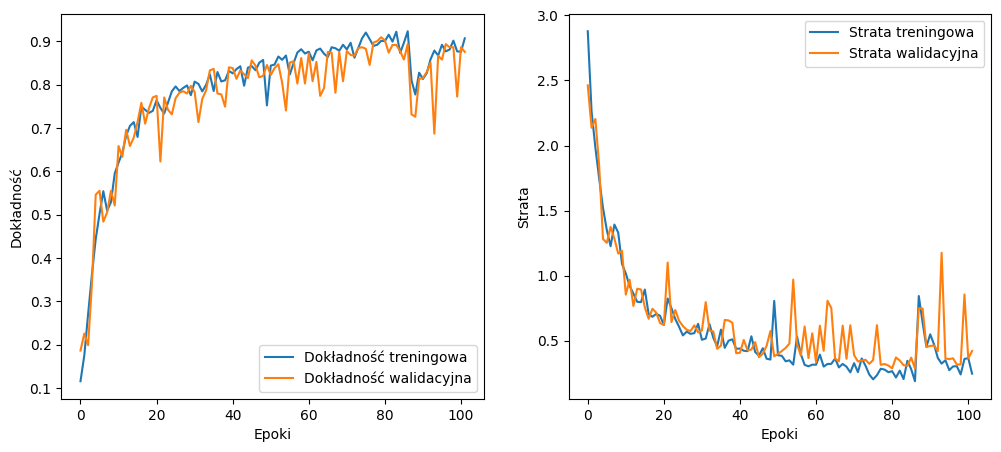

Trening zatrzymany w epoce: 101
Najlepsza wartość walidacyjnej dokładności: 0.9092526435852051
18/18 [==============================] - 0s 10ms/step - loss: 0.2101 - categorical_accuracy: 0.9218
Finalna wartość categorical_accuracy na zestawie testowym: 0.9218472242355347
Finalna wartość loss na zestawie testowym: 0.2101057916879654


In [20]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_lstm.history['categorical_accuracy'], label='Dokładność treningowa')
plt.plot(history_lstm.history['val_categorical_accuracy'], label='Dokładność walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['loss'], label='Strata treningowa')
plt.plot(history_lstm.history['val_loss'], label='Strata walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

# Odczytanie atrybutów callbacku early stopping
print(f"Trening zatrzymany w epoce: {early_stopping.stopped_epoch}")
print(f"Najlepsza wartość walidacyjnej dokładności: {max(history_lstm.history['val_categorical_accuracy'])}")

# Ewaluacja modelu na zestawie testowym
test_loss, test_accuracy = model_lstm.evaluate(X_test, y_test)

print(f"Finalna wartość categorical_accuracy na zestawie testowym: {test_accuracy}")
print(f"Finalna wartość loss na zestawie testowym: {test_loss}")


## CNN

In [25]:
# Definicja modelu CNN
model_cnn = Sequential()
model_cnn.add(Conv1D(32, 3, activation='relu', input_shape=(30, 258)))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Dropout(0.1))
model_cnn.add(Conv1D(64, 3, activation='relu'))
model_cnn.add(MaxPooling1D(2))
model_cnn.add(Dropout(0.1))
model_cnn.add(Flatten())
model_cnn.add(Dense(64, activation='relu'))
model_cnn.add(Dropout(0.1))
model_cnn.add(Dense(actions.shape[0], activation='softmax'))

In [26]:
# Kompilacja modelu CNN
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Trenowanie modelu CNN
history_cnn = model_cnn.fit(
    X_train, y_train, 
    epochs=500, 
    batch_size=16, 
    callbacks=[early_stopping],
    validation_data=(X_val, y_val)
)

Epoch 1/500
165/165 [==============================] - 2s 7ms/step - loss: 2.7988 - accuracy: 0.1276 - val_loss: 2.2466 - val_accuracy: 0.1993
Epoch 2/500
165/165 [==============================] - 1s 5ms/step - loss: 1.9126 - accuracy: 0.3349 - val_loss: 1.5236 - val_accuracy: 0.4786
Epoch 3/500
165/165 [==============================] - 1s 5ms/step - loss: 1.4144 - accuracy: 0.4922 - val_loss: 1.1180 - val_accuracy: 0.5409
Epoch 4/500
165/165 [==============================] - 1s 5ms/step - loss: 1.1036 - accuracy: 0.5958 - val_loss: 0.8225 - val_accuracy: 0.7064
Epoch 5/500
165/165 [==============================] - 1s 6ms/step - loss: 0.8926 - accuracy: 0.6724 - val_loss: 0.7793 - val_accuracy: 0.6940
Epoch 6/500
165/165 [==============================] - 1s 6ms/step - loss: 0.8968 - accuracy: 0.6792 - val_loss: 0.6724 - val_accuracy: 0.7758
Epoch 7/500
165/165 [==============================] - 1s 6ms/step - loss: 0.7156 - accuracy: 0.7402 - val_loss: 0.6086 - val_accuracy: 0.7989

In [36]:
model_cnn.save('CNN', save_format='tf')

INFO:tensorflow:Assets written to: CNN\assets


INFO:tensorflow:Assets written to: CNN\assets


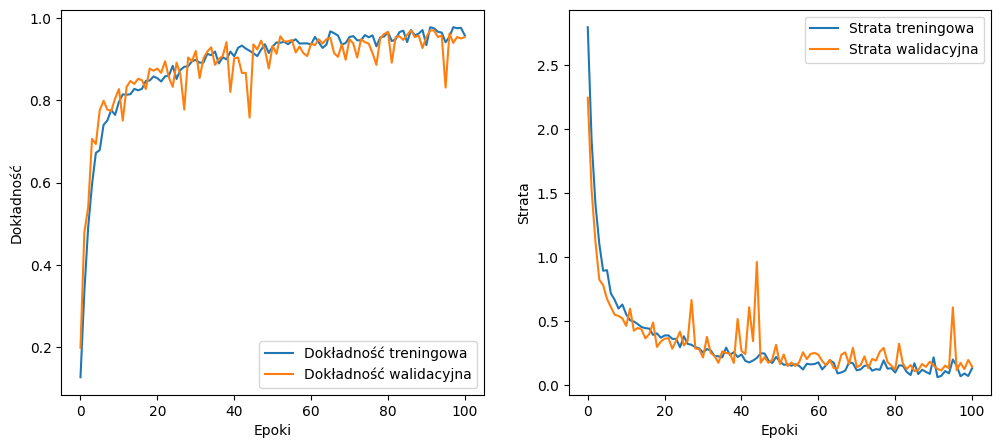

Trening zatrzymany w epoce: 100
Najlepsza wartość walidacyjnej dokładności: 0.9697508811950684
18/18 [==============================] - 0s 4ms/step - loss: 0.0728 - accuracy: 0.9734
Finalna wartość categorical_accuracy na zestawie testowym: 0.9733570218086243
Finalna wartość loss na zestawie testowym: 0.07277537137269974


In [28]:
import matplotlib.pyplot as plt

# Plotting accuracy
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_cnn.history['accuracy'], label='Dokładność treningowa')
plt.plot(history_cnn.history['val_accuracy'], label='Dokładność walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Dokładność')
plt.legend()

# Plotting loss
plt.subplot(1, 2, 2)
plt.plot(history_cnn.history['loss'], label='Strata treningowa')
plt.plot(history_cnn.history['val_loss'], label='Strata walidacyjna')
plt.xlabel('Epoki')
plt.ylabel('Strata')
plt.legend()

plt.show()

# Odczytanie atrybutów callbacku early stopping
print(f"Trening zatrzymany w epoce: {early_stopping.stopped_epoch}")
print(f"Najlepsza wartość walidacyjnej dokładności: {max(history_cnn.history['val_accuracy'])}")

# Ewaluacja modelu na zestawie testowym
test_loss, test_accuracy = model_cnn.evaluate(X_test, y_test)

print(f"Finalna wartość categorical_accuracy na zestawie testowym: {test_accuracy}")
print(f"Finalna wartość loss na zestawie testowym: {test_loss}")


## Ocena Modeli

Metryki precision    recall  f1-score   support

In [39]:
# Predykcje dla modelu LSTM
y_pred_lstm = model_lstm.predict(X_test)
y_pred_classes_lstm = np.argmax(y_pred_lstm, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

# Predykcje dla modelu CNN
y_pred_cnn = model_cnn.predict(X_test)
y_pred_classes_cnn = np.argmax(y_pred_cnn, axis=1)

# Metryki dla modelu LSTM
accuracy_lstm = accuracy_score(y_true_classes, y_pred_classes_lstm)
cm_lstm = confusion_matrix(y_true_classes, y_pred_classes_lstm)
mse_lstm = mean_squared_error(y_test, y_pred_lstm)
rmse_lstm = np.sqrt(mse_lstm)
mae_lstm = mean_absolute_error(y_test, y_pred_lstm)

print(f'LSTM Accuracy: {accuracy_lstm}')
print(f'LSTM MSE: {mse_lstm}')
print(f'LSTM RMSE: {rmse_lstm}')
print(f'LSTM MAE: {mae_lstm}')
print('LSTM Classification Report:')
print(classification_report(y_true_classes, y_pred_classes_lstm, target_names=actions))

# Metryki dla modelu CNN
accuracy_cnn = accuracy_score(y_true_classes, y_pred_classes_cnn)
cm_cnn = confusion_matrix(y_true_classes, y_pred_classes_cnn)
mse_cnn = mean_squared_error(y_test, y_pred_cnn)
rmse_cnn = np.sqrt(mse_cnn)
mae_cnn = mean_absolute_error(y_test, y_pred_cnn)

print(f'CNN Accuracy: {accuracy_cnn}')
print(f'CNN MSE: {mse_cnn}')
print(f'CNN RMSE: {rmse_cnn}')
print(f'CNN MAE: {mae_cnn}')
print('CNN Classification Report:')
print(classification_report(y_true_classes, y_pred_classes_cnn, target_names=actions))


18/18 [==============================] - 0s 4ms/step
LSTM Accuracy: 0.9218472468916519
LSTM MSE: 0.004292821329231668
LSTM RMSE: 0.06551962552725456
LSTM MAE: 0.008413531257796654
LSTM Classification Report:
              precision    recall  f1-score   support

         car       1.00      0.95      0.98        21
      coffee       0.92      1.00      0.96        36
        face       0.96      1.00      0.98        23
        fall       1.00      1.00      1.00        30
      friday       0.75      0.75      0.75        12
        gold       1.00      0.96      0.98        23
     goodbye       0.86      1.00      0.92        18
       heart       1.00      1.00      1.00        24
       hello       1.00      1.00      1.00        24
    iloveyou       0.65      0.65      0.65        23
         key       1.00      1.00      1.00        22
      monday       0.57      0.76      0.65        17
       music       1.00      1.00      1.00        24
       phone       1.00      1.00  

Confusion matrix

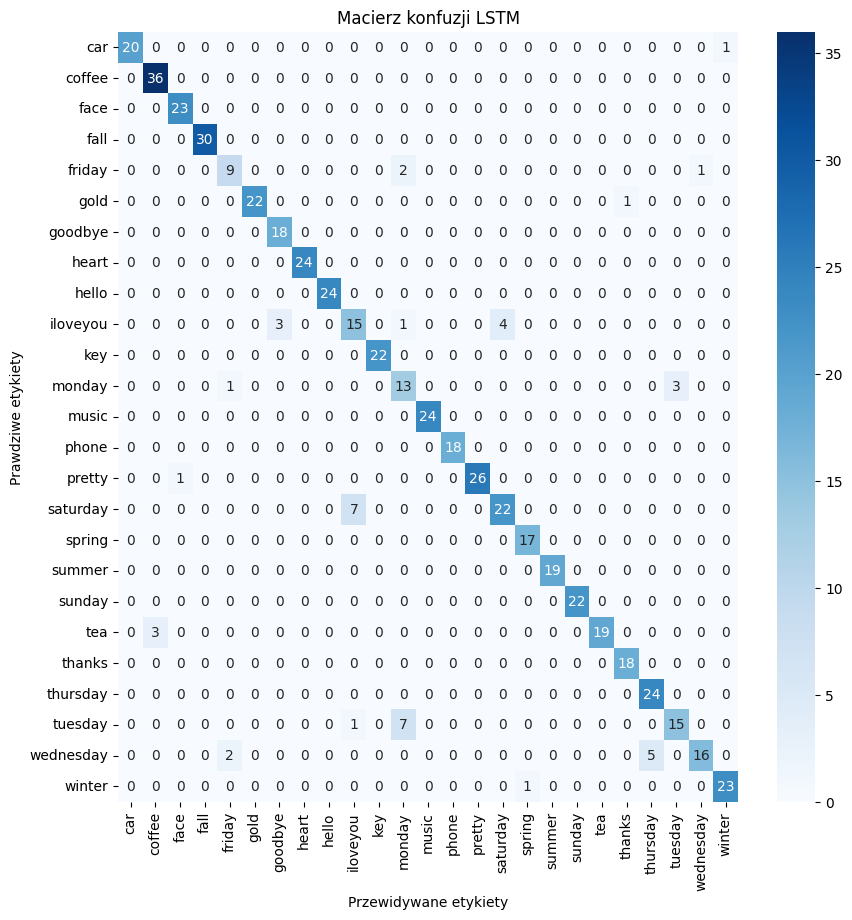

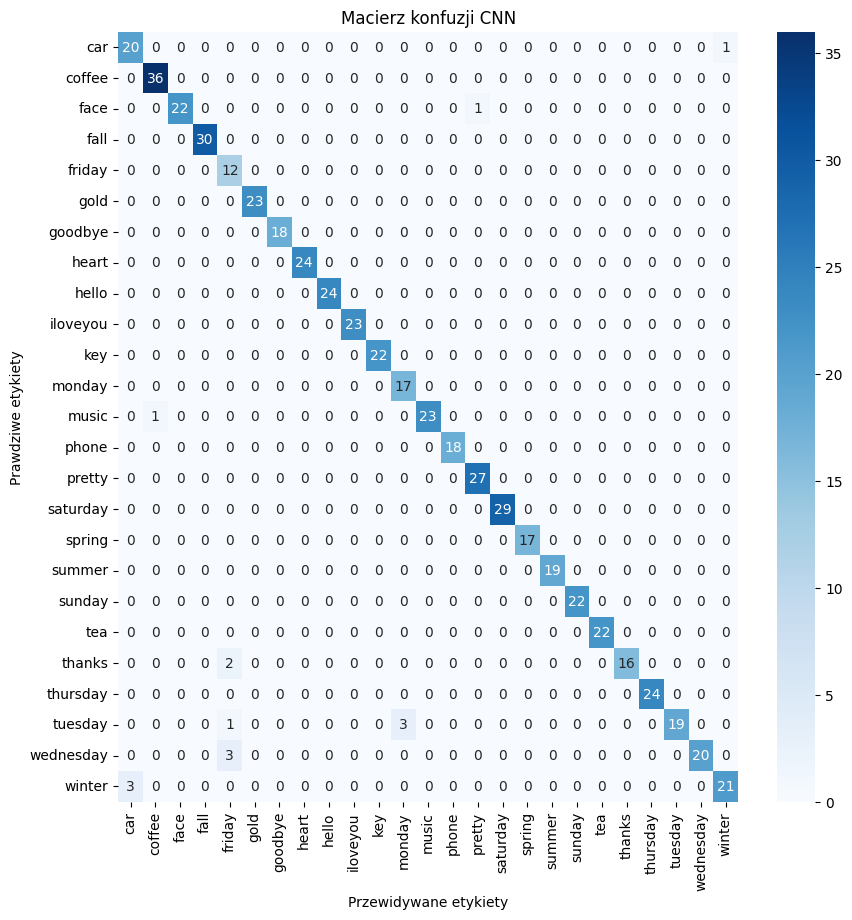

In [40]:
# Rysowanie macierzy konfuzji
def plot_confusion_matrix(cm, class_names, title='Macierz konfuzji'):
    fig, ax = plt.subplots(figsize=(10, 10))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax, xticklabels=class_names, yticklabels=class_names)
    ax.set_title(title)
    ax.set_xlabel('Przewidywane etykiety')
    ax.set_ylabel('Prawdziwe etykiety')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.show()

# Rysowanie macierzy konfuzji
plot_confusion_matrix(cm_lstm, actions, title='Macierz konfuzji LSTM')
plot_confusion_matrix(cm_cnn, actions, title='Macierz konfuzji CNN')


Wykrsy loss i accuracy

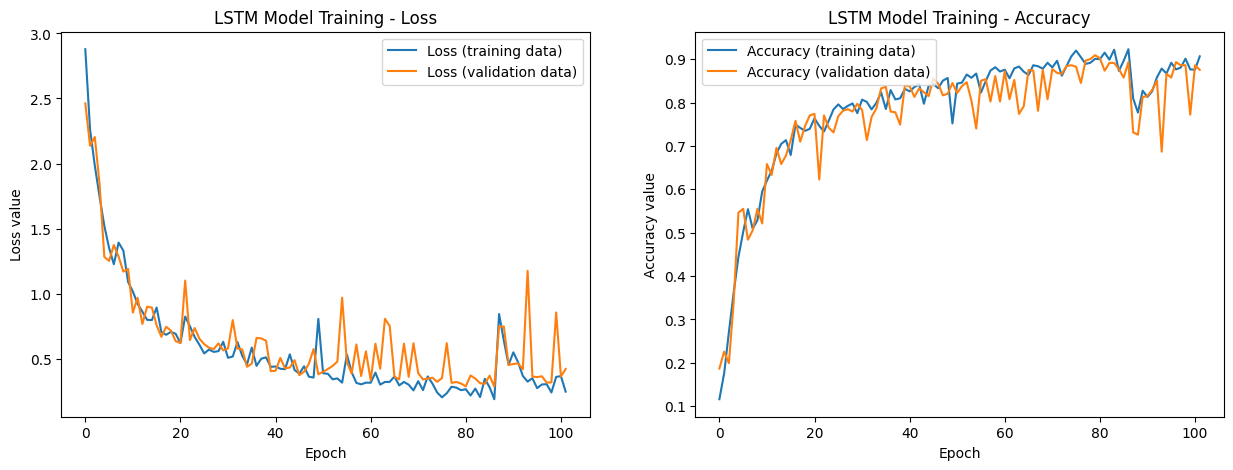

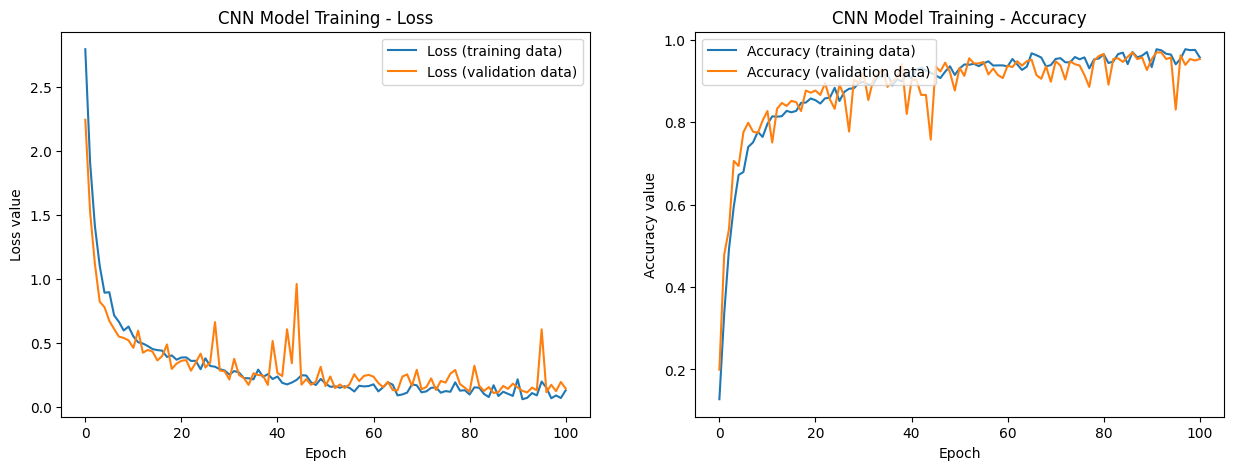

In [33]:
# Funkcja do tworzenia wykresów strat i dokładności
def plot_training_history(history, title='Model Training'):
    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    
    # Wykres strat
    axs[0].plot(history.history['loss'], label='Loss (training data)')
    axs[0].plot(history.history['val_loss'], label='Loss (validation data)')
    axs[0].set_title(f'{title} - Loss')
    axs[0].set_ylabel('Loss value')
    axs[0].set_xlabel('Epoch')
    axs[0].legend(loc="upper right")

    # Wykres dokładności
    accuracy_key = 'accuracy' if 'accuracy' in history.history else 'categorical_accuracy'
    val_accuracy_key = 'val_' + accuracy_key
    axs[1].plot(history.history[accuracy_key], label='Accuracy (training data)')
    axs[1].plot(history.history[val_accuracy_key], label='Accuracy (validation data)')
    axs[1].set_title(f'{title} - Accuracy')
    axs[1].set_ylabel('Accuracy value')
    axs[1].set_xlabel('Epoch')
    axs[1].legend(loc="upper left")
    
    plt.show()

# Wykresy dla modelu LSTM
plot_training_history(history_lstm, title='LSTM Model Training')

# Wykresy dla modelu CNN
plot_training_history(history_cnn, title='CNN Model Training')


Krzywa ROC

18/18 [==============================] - 0s 3ms/step


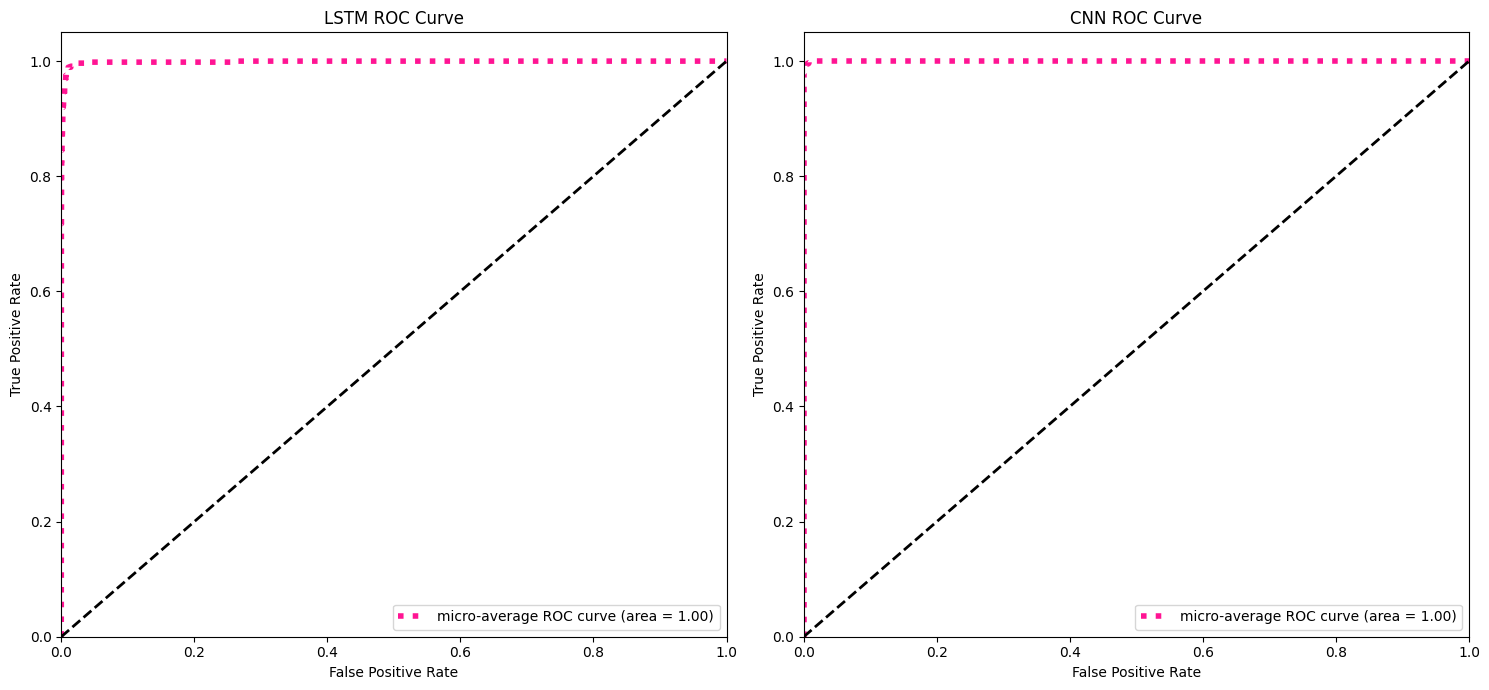

In [34]:
# Binarizacja etykiet dla wieloklasowej klasyfikacji
y_test_bin = label_binarize(y_true_classes, classes=range(len(actions)))
n_classes = y_test_bin.shape[1]

# Predykcje prawdopodobieństw
y_score_lstm = model_lstm.predict(X_test)
y_score_cnn = model_cnn.predict(X_test)

# Obliczanie ROC curve i ROC area dla każdego modelu i klasy
fpr_lstm = dict()
tpr_lstm = dict()
roc_auc_lstm = dict()
fpr_cnn = dict()
tpr_cnn = dict()
roc_auc_cnn = dict()

for i in range(n_classes):
    fpr_lstm[i], tpr_lstm[i], _ = roc_curve(y_test_bin[:, i], y_score_lstm[:, i])
    roc_auc_lstm[i] = auc(fpr_lstm[i], tpr_lstm[i])
    fpr_cnn[i], tpr_cnn[i], _ = roc_curve(y_test_bin[:, i], y_score_cnn[:, i])
    roc_auc_cnn[i] = auc(fpr_cnn[i], tpr_cnn[i])

# Obliczanie micro-average ROC curve i ROC area
fpr_lstm["micro"], tpr_lstm["micro"], _ = roc_curve(y_test_bin.ravel(), y_score_lstm.ravel())
roc_auc_lstm["micro"] = auc(fpr_lstm["micro"], tpr_lstm["micro"])

fpr_cnn["micro"], tpr_cnn["micro"], _ = roc_curve(y_test_bin.ravel(), y_score_cnn.ravel())
roc_auc_cnn["micro"] = auc(fpr_cnn["micro"], tpr_cnn["micro"])

# Plot ROC curves
plt.figure(figsize=(15, 7))
plt.subplot(1, 2, 1)
plt.plot(fpr_lstm["micro"], tpr_lstm["micro"],
         label=f'micro-average ROC curve (area = {roc_auc_lstm["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('LSTM ROC Curve')
plt.legend(loc="lower right")

plt.subplot(1, 2, 2)
plt.plot(fpr_cnn["micro"], tpr_cnn["micro"],
         label=f'micro-average ROC curve (area = {roc_auc_cnn["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)
plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('CNN ROC Curve')
plt.legend(loc="lower right")

plt.tight_layout()
plt.show()
